In [1]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 19.2MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=30fe8292ff31a3c4579737f5078ff0efa2733fd411b276c9ba7b1a7e5c417121
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
!pip install chart-studio

     |████████████████████████████████| 71kB 4.9MB/s 


In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import math, time
import plotly.express as px
import plotly.graph_objects as go
import chart_studio.plotly as py
import chart_studio
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2738 entries, 2010-01-04 to 2020-11-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2738 non-null   float64
dtypes: float64(1)
memory usage: 42.8 KB
x_train.shape =  (2174, 19, 1)
y_train.shape =  (2174, 1)
x_test.shape =  (544, 19, 1)
y_test.shape =  (544, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch  0 MSE:  0.5894286036491394
Epoch  1 MSE:  0.21824873983860016
Epoch  2 MSE:  0.0415324866771698
Epoch  3 MSE:  0.1834099143743515
Epoch  4 MSE:  0.11564745008945465
Epoch  5 MSE:  0.04320012405514717
Epoch  6 MSE:  0.047956328839063644
Epoch  7 MSE:  0.07598724961280823
Epoch  8 MSE:  0.08634750545024872
Epoch  9 MSE:  0.0762370228767395
Epoch  10 MSE:  0.05679967999458313
Epoch  11 MSE:  0.039781276136636734
Epoch  12 MSE:  0.03294472023844719
Epoch  13 MSE:  0.03719475865364075
Epoch  14 MSE:  0.04575049504637718
Epoch  15 MSE:  0.04936866834759712
Epoch  16 MSE:  0.04470594972372055
Epoch  17 MSE:  0.035882119089365005
Epoch  18 MSE:  0.02892662212252617
Epoch  19 MSE:  0.026757314801216125
Epoch  20 MSE:  0.028380921110510826
Epoch  21 MSE:  0.030842775478959084
Epoch  22 MSE:  0.03145959600806236
Epoch  23 MSE:  0.02911761775612831
Epoch  24 MSE:  0.024528035894036293
Epoch  25 MSE:  0.019681282341480255
Epoch  26 MSE:  0.016694845631718636
Epoch  27 MSE:  0.016367712989449

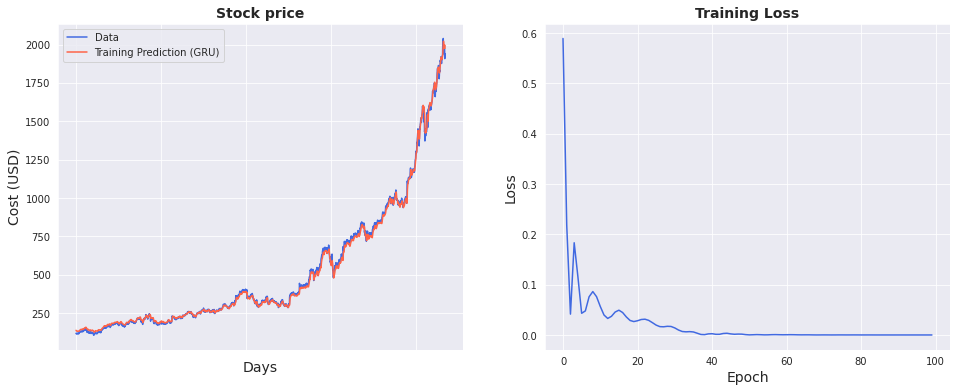

In [4]:
# download data from yahoo finance
data = yf.download("AMZN",start = "2010-01-01",end = "2020-11-17")

# using close data
price = data[["Close"]]
price.info()
scaler = MinMaxScaler(feature_range=(-1, 1))
price["Close"] = scaler.fit_transform(price["Close"].values.reshape(-1,1))

# define train data(80%) and test data(20%) 
def split_data(stock, lookback):
    # convert to numpy array
    data_raw = stock.to_numpy() 
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    return [x_train, y_train, x_test, y_test]

# choose sequence length
lookback = 20 
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

# convert to Tensor
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

# setup dimension and layer 
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

# create GRU model
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
# lr = 0.01
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)            

hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

# invert data
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

# plot setup
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()